In [ ]:
import numpy as np
import random
import math
import heapq
import multiprocess as mp
import talib as ta
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from datetime import datetime,date
import time
from island_ga import IslandGGA 
from chromosome import Chromosome 
from data_preprocessing import Data
from single_data_processing import SingleAssetTI
import itertools
import yfinance as yf
import datetime
from pso import PSOPortfolioOptimizer

[*********************100%***********************]  1 of 1 completed


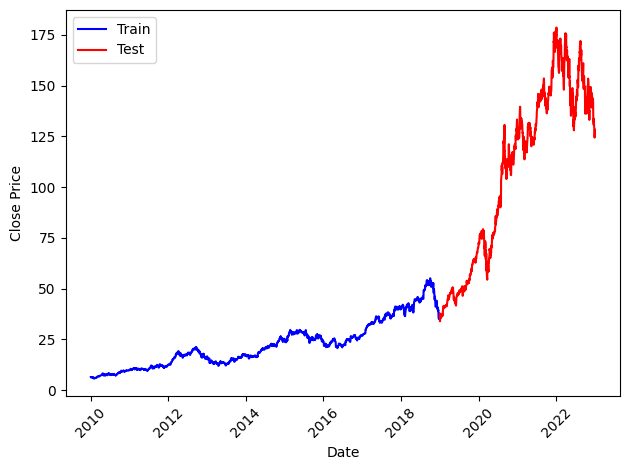

In [4]:
start_date = datetime.datetime(2010, 1, 1)
end_date = datetime.datetime(2022, 12, 31)
period ="train"
data = Data('AAPL',start_date,end_date,period,2019)
data.data_preprocess()

In [5]:
import time
import numpy as np

# Initialize result dictionaries
fitness_values = {alg: [] for alg in ["ring", "multikuti", "master_slave", "gga", "pso"]}
test_fitness_values = {alg: [] for alg in fitness_values}
speed_values = {alg: [] for alg in fitness_values}
profit = {alg: [] for alg in fitness_values}
test_profit = {alg: [] for alg in fitness_values}
mdd = {alg: [] for alg in fitness_values}
test_mdd = {alg: [] for alg in fitness_values}

# List of algorithms to compare
evolve_strategies = ["ring", "multikuti", "master_slave", "gga", "pso"]

# Number of repetitions per algorithm for statistical robustness
num_runs = 10

for strategy in evolve_strategies:
    print(f"Running strategy: {strategy}")
    for run in range(num_runs):
        start_time = time.time()
        
        if strategy != "pso":
            # Initialize and run GA
            ga = IslandGGA(
                data=data.train_data,
                K=4,
                num_islands=10,
                m_iter=10,
                num_iter=50,
                pSize=150,
                strategies=data.strategies,
                evolve_strategy=strategy
            )
            ga.evolve()

            # Record training results
            fitness_values[strategy].append(ga.globalBest.fitness_value)
            profit[strategy].append(ga.globalBest.profit)
            mdd[strategy].append(ga.globalBest.mdd)

            # Evaluate on test data
            ga.globalBest.calculate_chromosome_fitness(data.test_data, allocated_capital=1)
            test_fitness_values[strategy].append(ga.globalBest.fitness_value)
            test_profit[strategy].append(ga.globalBest.profit)
            test_mdd[strategy].append(ga.globalBest.mdd)

        else:
            # Initialize and run PSO
            pso = PSOPortfolioOptimizer(
                data=data.train_data,
                strategies=data.strategies
            )
            train_profit, train_mdd, train_fitness = pso.run()
            

            # Evaluate on training data
            
            profit["pso"].append(train_profit)
            mdd["pso"].append(train_mdd)
            fitness_values["pso"].append(train_fitness)

            # Evaluate on test data
            test_profit_val, test_mdd_val, test_fitness_val = pso.evaluate_on_data(data.test_data)
            test_profit["pso"].append(test_profit_val)
            test_mdd["pso"].append(test_mdd_val)
            test_fitness_values["pso"].append(test_fitness_val)
        ## time
        end_time = time.time()
        speed_values[strategy].append(end_time - start_time)
        

print("All strategies completed.")



Running strategy: ring
Running ring
Generation 1: Best fitness = 13.632647921767706  Average Fitness = 6.0892834097494815
Generation 2: Best fitness = 13.632647921767706  Average Fitness = 7.325942689673184
Generation 3: Best fitness = 13.632647921767706  Average Fitness = 8.079457050678368
Generation 4: Best fitness = 13.632647921767706  Average Fitness = 8.970614025347036
Generation 5: Best fitness = 13.632647921767706  Average Fitness = 8.838223854928211
Generation 6: Best fitness = 14.60300492201949  Average Fitness = 9.142191174295553
Generation 7: Best fitness = 14.60300492201949  Average Fitness = 9.424635474230659
Generation 8: Best fitness = 14.60300492201949  Average Fitness = 9.454779561324546
Generation 9: Best fitness = 14.60300492201949  Average Fitness = 10.068104496554408
Generation 10: Best fitness = 14.60300492201949  Average Fitness = 9.699442390845965
Island 0 Migration - Left 9 - Right 1
Island 1 Migration - Left 0 - Right 2
Island 2 Migration - Left 1 - Right 3
Is

/Users/kudakwashechideme/repos/genetic_algo_venv/lib/python3.9/site-packages/numpy/core/fromnumeric.py:57: RuntimeWarning: overflow encountered in accumulate
  return bound(*args, **kwds)
/Users/kudakwashechideme/repos/island_genetic_algrorithm/pso.py:151: RuntimeWarning: invalid value encountered in double_scalars
  return profit / mdd if mdd > 0.01 else profit


All strategies completed.


In [6]:
import os
import pandas as pd

# Create a directory for downtrend results
os.makedirs("results/uptrend", exist_ok=True)

# Save each as CSV
pd.DataFrame(fitness_values).to_csv("results/uptrend/fitness_values.csv", index=False)
pd.DataFrame(test_fitness_values).to_csv("results/uptrend/test_fitness_values.csv", index=False)

pd.DataFrame(profit).to_csv("results/uptrend/profit.csv", index=False)
pd.DataFrame(test_profit).to_csv("results/uptrend/test_profit.csv", index=False)
pd.DataFrame(mdd).to_csv("results/uptrend/mdd.csv", index=False)
pd.DataFrame(test_mdd).to_csv("results/uptrend/test_mdd.csv", index=False)
#pd.DataFrame(speed_values).to_csv("results/downtrend/speed_values.csv", index=False)


In [7]:
def summarize_metrics(metric_dict, metric_name):
    df = pd.DataFrame(metric_dict)
    summary = df.agg(['mean', 'std', 'min', 'max']).T
    summary.columns = [f"{metric_name}_{stat}" for stat in summary.columns]
    return summary

# Summarize each metric
#fitness_df = summarize_metrics(fitness_values, "fitness")
#test_fitness_df = summarize_metrics(test_fitness_values, "test_fitness")
profit_df = summarize_metrics(profit, "profit")
test_profit_df = summarize_metrics(test_profit, "test_profit")
mdd_df = summarize_metrics(mdd, "mdd")
test_mdd_df = summarize_metrics(test_mdd, "test_mdd")
#speed_df = summarize_metrics(speed_values, "runtime")

# Merge all into one table
summary_table = pd.concat([
    
    profit_df, test_profit_df,
    mdd_df, test_mdd_df,
   
], axis=1)

# Round for neatness
summary_table = summary_table.round(4)

# Display
print(summary_table)

              profit_mean  profit_std    profit_min  profit_max  \
ring               2.9453      0.2108  2.686600e+00      3.2641   
multikuti          2.8357      0.1789  2.596200e+00      3.1525   
master_slave       2.9073      0.2339  2.619200e+00      3.2741   
gga                2.8149      0.4869  1.744000e+00      3.4686   
pso                   inf         NaN  5.282202e+95         inf   

              test_profit_mean  test_profit_std  test_profit_min  \
ring              1.391000e+00     1.904000e-01     1.056400e+00   
multikuti         1.379000e+00     1.764000e-01     1.051000e+00   
master_slave      1.401200e+00     1.959000e-01     1.103200e+00   
gga               1.410900e+00     2.680000e-01     9.330000e-01   
pso              9.750969e+149    3.473305e+150   -1.063471e+150   

              test_profit_max  mdd_mean  mdd_std       mdd_min  mdd_max  \
ring             1.614300e+00    0.1876   0.0156  1.566000e-01   0.2057   
multikuti        1.602900e+00    0.180

/Users/kudakwashechideme/repos/genetic_algo_venv/lib/python3.9/site-packages/pandas/core/series.py:2602: RuntimeWarning: overflow encountered in multiply
  result = self._values.round(decimals)
